In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sbs


from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import *

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

22/09/27 15:39:52 WARN Utils: Your hostname, CLs-Laptop resolves to a loopback address: 127.0.1.1; using 172.30.186.150 instead (on interface eth0)
22/09/27 15:39:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/27 15:39:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
full = spark.read.parquet('../data/curated/train_data/')
full = full.withColumnRenamed('y_total_num_consumer', 'next_total_num_consumer').withColumnRenamed('y_total_revenue', 'next_total_revenue')\
    .withColumnRenamed('y_total_num_transaction', 'next_total_num_transaction')
full.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- total_num_consumer: long (nullable = true)
 |-- avg_dollar_value: double (nullable = true)
 |-- total_num_transaction: long (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- total_revenue: double (nullable = true)
 |-- total_num_postcode: long (nullable = true)
 |-- tag: string (nullable = true)
 |-- next_total_num_consumer: long (nullable = true)
 |-- next_total_revenue: double (nullable = true)
 |-- next_total_num_transaction: long (nullable = true)



In [4]:
tag_mean = full.groupBy('tag')\
      .agg(
         F.mean("total_revenue").alias("mean_revenue_of_tags")
      )

In [5]:
tag_mean = tag_mean.toPandas()
kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(tag_mean['mean_revenue_of_tags']).reshape(-1, 1))
tag_mean['tag_labels'] = kmeans.labels_

In [6]:
tag_mean_sdf = spark.createDataFrame(tag_mean[['tag', 'tag_labels']])

In [7]:
full = full.join(tag_mean_sdf, ["tag"], how="left") 
full

tag,merchant_abn,total_num_consumer,avg_dollar_value,total_num_transaction,mean_income,revenue_level,total_revenue,total_num_postcode,next_total_num_consumer,next_total_revenue,next_total_num_transaction,tag_labels
cable,10142254217,731,41.119659381592804,750,62693.954666666665,b,130143.71547230528,642,918,154467.9209189612,925,0
watch,10187291046,87,111.08408713922161,87,61060.0459770115,b,31795.59789319502,87,99,41683.211213258364,100,0
watch,10264435225,1238,114.10783402533238,1272,62006.311320754714,c,346896.9592900661,1018,1519,435003.67956298945,1566,0
artist supply,10385011947,6,526.8134669489664,6,55291.166666666664,b,10019.992382525408,6,9,18926.917288619916,9,1
artist supply,10463252268,22,464.09649768506534,22,60070.77272727273,a,67488.91405656066,22,26,78474.65405470505,26,1
artist supply,10487253336,629,449.0344083022497,635,63669.83464566929,b,1117736.4709001747,587,715,1206457.0200268542,733,1
florists,10385163239,17,350.0866763834393,17,58553.117647058825,a,39339.24061981452,16,22,52838.18504617854,22,1
music,10192359162,107,451.1432080236007,107,65637.3831775701,a,305563.80254357896,107,109,306970.12786372635,109,0
music,10364012396,4,276.0868936989199,4,81123.75,b,4008.7818228908677,4,16,19636.79081402693,16,0
books,10530696903,174,429.6262128784364,175,61263.58857142857,a,485692.4365271367,167,226,606552.0421588302,226,1


In [8]:
# change tags into numeric feature by one hot encoding
indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
full = indexer.fit(full).transform(full)
ohe = OneHotEncoder(inputCol="tagIndex", outputCol="tagOHE")
full = ohe.fit(full).transform(full)

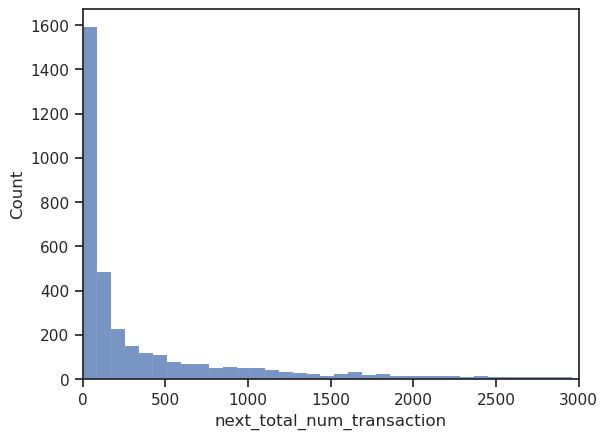

In [9]:

import matplotlib.pyplot as plt

full_df = full.toPandas()
sbs.set(style="ticks", color_codes=True)
fig = sbs.histplot(full_df["next_total_num_transaction"])
fig.set_xlim(0, 3000)
plt.show()


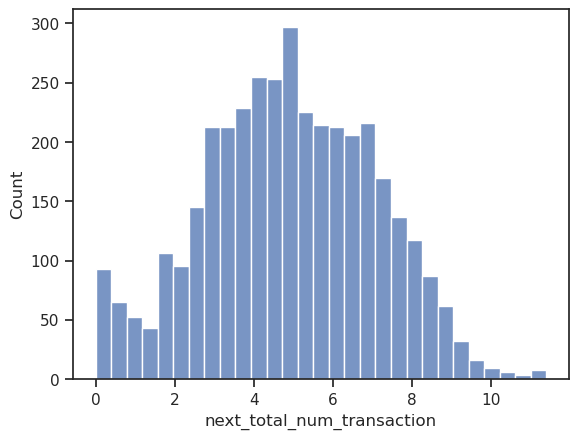

In [10]:
log_value=np.log(full_df["next_total_num_transaction"])
sbs.set(style="ticks", color_codes=True)
fig = sbs.histplot(log_value)
plt.show()


In [11]:
transaction_df = full.drop('merchant_abn', 'avg_dollar_value', 'mean_income', 'revenue_level', 'total_revenue', 'total_num_postcode', 'tag_labels', 'next_total_revenue', 'next_total_num_consumer')

In [12]:
import six
for i in transaction_df.columns[:-1]:
    if not( isinstance(transaction_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to next_total_num_transaction for ", i, transaction_df.stat.corr('next_total_num_transaction',i))

Correlation to next_total_num_transaction for  total_num_consumer 0.9244448335517905
Correlation to next_total_num_transaction for  total_num_transaction 0.9998751179400183
Correlation to next_total_num_transaction for  next_total_num_transaction 1.0
Correlation to next_total_num_transaction for  tagIndex -0.09320240325517762


In [13]:
features = ['total_num_consumer', 'total_num_transaction']
assembler = VectorAssembler(inputCols=features, outputCol='features')
final_transaction_df = assembler.transform(transaction_df)
final_transaction_df = final_transaction_df.select('features','next_total_num_transaction')
final_transaction_df

features,next_total_num_transaction
"[8.0,8.0]",null
"[12.0,12.0]",1
"[1.0,1.0]",null
"[2.0,2.0]",null
"[1.0,1.0]",null
"[33.0,33.0]",3
"[29.0,29.0]",null
"[3.0,3.0]",null
"[1.0,1.0]",null
"[1.0,1.0]",null


In [14]:
# missing values will not be included
train_df, test_df = (final_transaction_df.drop('tag', 'tagIndex').filter(F.col('next_total_num_transaction').isNotNull())).randomSplit([0.7, 0.3])
train_df.count(), test_df.count()

(2646, 1134)

#### Linear Regression

In [15]:
lr = LinearRegression(labelCol='next_total_num_transaction', maxIter=10, regParam=0.3, elasticNetParam=0.8)
fitted_model = lr.fit(train_df)
fitted_model.setFeaturesCol("features")
fitted_model.setPredictionCol("prediction")

22/09/27 15:40:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/09/27 15:40:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


LinearRegressionModel: uid=LinearRegression_9e734dccb025, numFeatures=2

In [16]:
print("Coefficients: %s" % str(fitted_model.coefficients))
print("Intercept: %s" % str(fitted_model.intercept))

Coefficients: [-0.006087136442855128,1.2111219820819443]
Intercept: -13.3325581904588


In [17]:
trainingSummary = fitted_model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 10
objectiveHistory: [0.5000000000000001, 0.3671917830174766, 0.1034877715514202, 0.014175804409476599, 0.010165647943693953, 0.00021824847175629133, 0.00019780701631382498, 0.00019608629080635978, 0.0001959484133032699, 0.00019589828370608094, 0.00019582027914477542]
+------------------+
|         residuals|
+------------------+
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 13.12752334481971|
| 14.12752334481971|
| 14.12752334481971|
| 15.12752334481971|
| 15.12752334481971|
| 15.12752334481971|
| 16.12752334481971|
| 17.12752334481971|
|11.922488499180622|
|11.922488499180622|
+------------------+
only showing top 20 rows

RMSE: 73.002726
r2: 0.999730


In [18]:
lr_predictions = fitted_model.transform(test_df)
lr_predictions.select("prediction","next_total_num_transaction","features").show(10)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="next_total_num_transaction",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-------------------+--------------------------+---------+
|         prediction|next_total_num_transaction| features|
+-------------------+--------------------------+---------+
| -12.12752334481971|                         1|[1.0,1.0]|
| -12.12752334481971|                         1|[1.0,1.0]|
| -12.12752334481971|                         1|[1.0,1.0]|
| -12.12752334481971|                         1|[1.0,1.0]|
| -12.12752334481971|                         4|[1.0,1.0]|
|-10.922488499180622|                         1|[2.0,2.0]|
|-10.922488499180622|                         1|[2.0,2.0]|
|-10.922488499180622|                         2|[2.0,2.0]|
|-10.922488499180622|                         3|[2.0,2.0]|
|-10.922488499180622|                         3|[2.0,2.0]|
+-------------------+--------------------------+---------+
only showing top 10 rows

R Squared (R2) on test data = 0.999803


#### deision tree

In [20]:
dt = DecisionTreeRegressor(labelCol='next_total_num_transaction')
model_dt = dt.fit(train_df)
result_dt= model_dt.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol='next_total_num_transaction', metricName="mae", predictionCol='prediction')
mae = dt_evaluator.evaluate(result_dt)
dt_evaluator = RegressionEvaluator(labelCol='next_total_num_transaction', metricName="r2", predictionCol='prediction')
r2 = dt_evaluator.evaluate(result_dt)
print('+++++++++++++++++++++++++++++++++++++++++++')
print(f'Using Categorical feature: {features}')
print('mae:{}'.format(mae))
print('r2: {}'.format(r2))

+++++++++++++++++++++++++++++++++++++++++++
Using Categorical feature: ['total_num_consumer', 'total_num_transaction']
mae:478.26458970811973
r2: 0.440732119599042


#### Random forest

In [21]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
rf = RandomForestRegressor(numTrees = 10, maxDepth = 10, labelCol='next_total_num_transaction')
model_rf = rf.fit(train_df)
result_rf = model_rf.transform(test_df)
rf_evaluator = RegressionEvaluator(labelCol='next_total_num_transaction', metricName="mae", predictionCol='prediction')
mae = rf_evaluator.evaluate(result_rf)
rf_evaluator = RegressionEvaluator(labelCol='next_total_num_transaction', metricName="r2", predictionCol='prediction')
r2 = rf_evaluator.evaluate(result_rf)
print('+++++++++++++++++++++++++++++++++++++++++++')
print(f'Using Categorical feature: {features}')
print('mae:{}'.format(mae))
print('r2: {}'.format(r2))


+++++++++++++++++++++++++++++++++++++++++++
Using Categorical feature: ['total_num_consumer', 'total_num_transaction']
mae:481.6055850066564
r2: 0.4364590297748071


#### GBTRegressor

In [22]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'next_total_num_transaction', maxIter=10)
model_gbt = gbt.fit(train_df)
result_gbt= model_gbt.transform(test_df)
gbt_evaluator = RegressionEvaluator(labelCol='next_total_num_transaction', metricName="mae", predictionCol='prediction')
mae = gbt_evaluator.evaluate(result_gbt)
gbt_evaluator = RegressionEvaluator(labelCol='next_total_num_transaction', metricName="r2", predictionCol='prediction')
r2 = gbt_evaluator.evaluate(result_gbt)
print('+++++++++++++++++++++++++++++++++++++++++++')
print(f'Using Categorical feature: {features}')
print('mae:{}'.format(mae))
print('r2: {}'.format(r2))

+++++++++++++++++++++++++++++++++++++++++++
Using Categorical feature: ['total_num_consumer', 'total_num_transaction']
mae:469.20339753850516
r2: 0.4407583896723165


### Neural Network

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

In [24]:
transaction_pd = transaction_df.toPandas().dropna()
transaction_pd

,tag,total_num_consumer,total_num_transaction,next_total_num_transaction,tagIndex,tagOHE
1,jewelry,12,12,1.0,23.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,jewelry,33,33,3.0,23.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,jewelry,108,108,10.0,23.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11,jewelry,5,5,1.0,23.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,jewelry,17,17,1.0,23.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
3948,bicycle,236,238,119.0,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3949,bicycle,25,25,16.0,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3950,bicycle,44,44,28.0,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3951,bicycle,8,8,3.0,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
features_pd = ['total_num_consumer', 'total_num_transaction']
X = transaction_pd[features_pd]
y = transaction_pd['next_total_num_transaction'].to_numpy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=30034, test_size=0.3)

In [27]:
# scale train and test dataset in order to be standard normally distributed with zero mean
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)
X_trainscaled.shape, X_testscaled.shape

((2646, 2), (1134, 2))

In [28]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(128,128,128, 128),activation="relu" ,solver = 'adam', random_state=30034, max_iter=20000)\
    .fit(X_trainscaled, y_train)
y_pred=mlp_reg.predict(X_testscaled)
print("The Score with ", (metrics.r2_score(y_pred, y_test)))

The Score with  0.9996046081852894


In [29]:
df_result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_result.head()

,Actual,Predicted
0,340.0,278.264425
1,121.0,118.378325
2,773.0,814.673399
3,24.0,23.664425
4,3113.0,3070.254108


In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 33.74338813344207
Mean Squared Error: 4414.489924813887
Root Mean Squared Error: 66.44162795126175
